In [1]:
from zamboni import DBConnector, Exporter
from zamboni.pd_helpers import filter_by_game_type, filter_by_season, filter_by_team, won_by_team, _wins_game
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.model_selection import LinearRegression

In [2]:
db_con = DBConnector('../data/zamboni.db')
conn = db_con.connect_db()

In [3]:
games_sql = 'SELECT * ' \
    'FROM games '

In [4]:
games_df = pd.read_sql(games_sql, conn)

### Goals per game by home and away teams

Mean goals scored by home team: 3.22
Mean goals scored by away team: 2.96


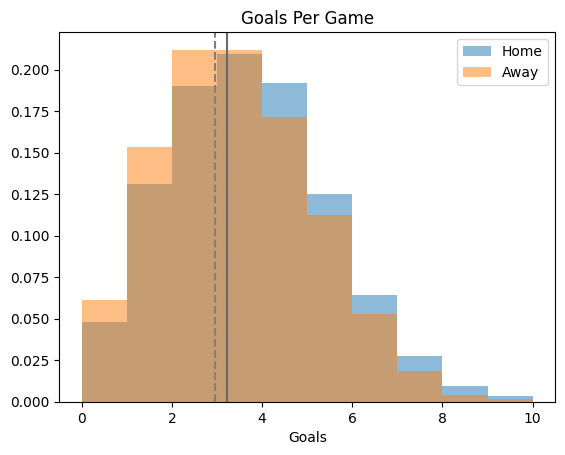

In [5]:
mean_home_goals = np.mean(games_df['homeTeamGoals'])
mean_away_goals = np.mean(games_df['awayTeamGoals'])
print(f'Mean goals scored by home team: {mean_home_goals:.2f}')
print(f'Mean goals scored by away team: {mean_away_goals:.2f}')
home_hist = plt.hist(games_df['homeTeamGoals'], bins=10, range=[0,10], alpha=0.5, label='Home', density=True)
plt.axvline(mean_home_goals, color='dimgray', linestyle='-')
away_hist = plt.hist(games_df['awayTeamGoals'], bins=10, range=[0,10], alpha=0.5, label='Away', density=True)
plt.axvline(mean_away_goals, color='gray', linestyle='--')
plt.title('Goals Per Game')
plt.xlabel('Goals')
plt.legend()
plt.show()

Mean goal differential (home - away): 0.26


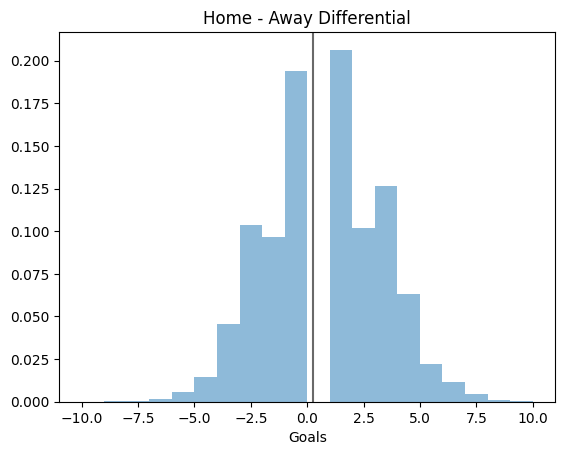

In [16]:
goal_differentials = games_df['homeTeamGoals'] - games_df['awayTeamGoals']
mean_differential = np.mean(goal_differentials)
print(f'Mean goal differential (home - away): {mean_differential:.2f}')
diff_hist = plt.hist(goal_differentials, bins=20, range=[-10,10], alpha=0.5, density=True)
plt.axvline(mean_differential, color='dimgray', linestyle='-')
plt.title('Home - Away Differential')
plt.xlabel('Goals')
plt.show()

Mean goal differential (won - lost): 2.27


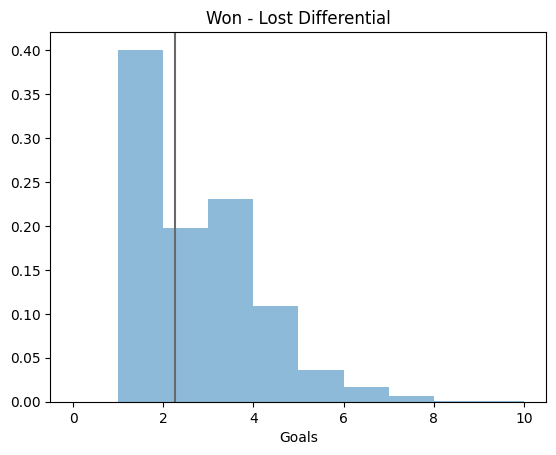

In [20]:
win_loss_differentials = np.where(games_df['homeTeamGoals'] > games_df['awayTeamGoals'], games_df['homeTeamGoals']-games_df['awayTeamGoals'], games_df['awayTeamGoals']-games_df['homeTeamGoals'])
mean_differential = np.mean(win_loss_differentials)
print(f'Mean goal differential (won - lost): {mean_differential:.2f}')
diff_hist = plt.hist(win_loss_differentials, bins=10, range=[0,10], alpha=0.5, density=True)
plt.axvline(mean_differential, color='dimgray', linestyle='-')
plt.title('Won - Lost Differential')
plt.xlabel('Goals')
plt.show()

In [ ]:
sql = 'SELECT * ' \
    'FROM games_per_team ' \
    'INNER JOIN games ON games_per_team.gameID = games.id ' \
    'INNER JOIN teams ON games_per_team.teamID = teams.id ' \
        
teams_sql = 'SELECT * FROM teams'

In [ ]:
df = pd.read_sql(sql, conn)
teams_info_df = pd.read_sql(teams_sql, conn)

In [ ]:
print(df)

In [ ]:
print(teams_info_df)

In [ ]:
print(df.iloc[0])

In [ ]:
season_id = 20222023

season_df = filter_by_season(df, season_id)
season_grouped_df = season_df.groupby(by='nameAbbrev', as_index=False)
win_df = season_grouped_df.agg({'won':['count','sum'], 'tied':['sum']})
win_df.columns = ['nameAbbrev', 'played','won','tied']

In [ ]:
records = win_df[['nameAbbrev', 'won_sum']].sort_values(by='won_sum', ascending=True)

abbrevs = records['nameAbbrev']
wins = records['won_sum']
ys = [2*i for i in range(len(records))]

fig, ax = plt.subplots(figsize=(10,10))
plt.barh(ys, wins)
plt.yticks(ys, abbrevs)
plt.title('Wins (2022-2023)', size=20)
plt.ylabel('Team')
plt.xlabel('Wins')
plt.show()

In [ ]:
a_df = filter_by_team(df, 1)
a_df = filter_by_game_type(a_df, 2)
a_df = filter_by_season(a_df, 20222023)
#a_df = won_by_team(a_df, 1)
print(len(a_df))
print(a_df)

In [ ]:
fil_df = a_df
fil_df['Won'] = df.apply(_wins_game, axis=1)
fil_df['Lost'] = ~fil_df['Won']
fil_df['WonLast'] = fil_df['Won'].shift(1)
fil_df['WonNext'] = fil_df['Won'].shift(-1)
fil_df['WonAndNext'] = fil_df['Won'] & fil_df['WonNext']
fil_df['LostWonNext'] = fil_df['Lost'] & fil_df['WonNext']

In [ ]:
print(fil_df.iloc[0])

In [ ]:
print(f'Games: {len(fil_df)}')
print(f'Wins: {sum(fil_df["Won"])}')
print(sum(fil_df['Won'])/len(fil_df))

In [ ]:
print(sum(fil_df[:-1]['WonAndNext']) / sum(fil_df[:-1]['Won']))
print(sum(fil_df[:-1]['LostWonNext']) / sum(fil_df[:-1]['Lost']))

## Games with all previous games (2022-2023)

#### Each row is a game and previous game for the same team and season. This is intended to allow for calculation of wins/record to date in that season for a game

In [ ]:
sql = 'SELECT games_per_team.gameID as gameID, ' \
        'games_per_team.won as won, ' \
        'games_per_team.teamID as teamID, ' \
        'games.datePlayed as datePlayed, ' \
        'games.seasonID as seasonID, ' \
        'other_games.datePlayed as prevDatePlayed, ' \
        'other_games_per_team.won as prevWon ' \
    'FROM games_per_team ' \
    'INNER JOIN games ON games_per_team.gameID = games.id ' \
    'INNER JOIN teams ON games_per_team.teamID = teams.id ' \
    'INNER JOIN games other_games ON games_per_team.teamID = other_games.homeTeamID ' \
        'OR games_per_team.teamID = other_games.awayTeamID ' \
    'INNER JOIN games_per_team other_games_per_team ON other_games.id = other_games_per_team.gameID ' \
        'AND games_per_team.teamID = other_games_per_team.teamID ' \
    'WHERE games.datePlayed > other_games.datePlayed ' \
        'AND games.seasonID = other_games.seasonID ' \
        'AND games.seasonID = 20222023 ' \
        
df = pd.read_sql(sql, conn)

In [ ]:
print(df)

In [ ]:
#team_df = df[df['teamID'] == 1]
#print(team_df)

In [ ]:
print(df[df['gameID'] == 2643][['teamID', 'gameID', 'won', 'datePlayed', 'prevDatePlayed', 'prevWon']])

## Games with win/goals summaries to date

In [ ]:
sql = 'SELECT gameID, '\
        'teamID, '\
		'seasonID, '\
		'won, '\
		'CAST(SUM(prevWon) AS REAL) / COUNT(*) AS prevWonPercentage, '\
        'CAST(SUM(prevGoals) AS REAL) / COUNT(*) AS prevGoalsScoredPerGame, '\
        'CAST(SUM(prevOppGoals) AS REAL) / COUNT(*) AS prevGoalsAgainstPerGame, '\
		'SUM(prevWon), '\
		'SUM(prevGoals), '\
		'SUM(prevOppGoals), '\
		'COUNT(*) '\
	'FROM games_with_previous '\
	'GROUP BY gameID, seasonID'

In [ ]:
df = pd.read_sql(sql, conn)

In [ ]:
print(df)

## Win percentage to date

In [ ]:
b, a = np.polyfit(df['prevWonPercentage'], df['won'], deg=1)
x_vals = np.linspace(0,1,100)
plt.plot(x_vals, a + b*x_vals, color='k')
plt.scatter(df['prevWonPercentage'], df['won'])
plt.title('Win vs. Previous Win Percentage')
plt.xlabel('Previous Win Percentage')
plt.ylabel('Win Y/N')
plt.show()

In [ ]:
win_mask = df['won'] == 1
lost_mask = np.logical_not(win_mask)
won_percentages = df['prevWonPercentage'][win_mask]
print('Mean previous win percentage when game is won:')
print(f'{round(np.mean(won_percentages)*100, 1)}%')

In [ ]:
lost_percentages = df['prevWonPercentage'][lost_mask]
print('Mean previous win percentage when game is lost:')
print(f'{round(np.mean(lost_percentages)*100, 1)}%')

In [ ]:
bins = [np.array([0,0.05]) + 0.05*n for n in range(20)]
win_percentages = df['prevWonPercentage']
outcomes = df['won']
plot_x = []
plot_y = []
for low_val, high_val in bins:
    above_mask = win_percentages > low_val
    below_mask = win_percentages < high_val
    mask = np.all([above_mask,below_mask], axis=0)
    binned_outcomes = outcomes[mask]
    if len(binned_outcomes) > 0:
        plot_y += [sum(binned_outcomes)/len(binned_outcomes)]
    else:
        plot_y += [0]
    plot_x += [(low_val + high_val)/2]

In [ ]:
b, a = np.polyfit(plot_x[4:16], plot_y[4:16], deg=1)
x_vals = np.linspace(0,1,100)
plt.scatter(plot_x, plot_y)
plt.plot(x_vals, a + b*x_vals)
plt.title('Average win percentage vs. binned previous win percentage')
plt.show()

## Average goals scored per game

In [ ]:
b, a = np.polyfit(df['prevGoalsScoredPerGame'], df['won'], deg=1)
x_vals = np.linspace(0,10,100)
plt.plot(x_vals, a + b*x_vals, color='k')
plt.scatter(df['prevGoalsScoredPerGame'], df['won'])
plt.title('Win vs. Previous Goals Scored Per Game')
plt.xlabel('Goals Per Game')
plt.ylabel('Win Y/N')
plt.show()

In [ ]:
b, a = np.polyfit(df['prevGoalsAgainstPerGame'], df['won'], deg=1)
x_vals = np.linspace(0,6,100)
plt.plot(x_vals, a + b*x_vals, color='k')
plt.scatter(df['prevGoalsAgainstPerGame'], df['won'])
plt.title('Win vs. Previous Goals Scored Per Game')
plt.xlabel('Goals Per Game')
plt.ylabel('Win Y/N')
plt.show()

## Won previous encounter between teams

In [ ]:
sql = 'SELECT gameID, '\
    'prevSameOppGameID, '\
	'teamID, '\
	'oppTeamID, '\
	'won, '\
	'prevWon '\
	'FROM ( SELECT gameID AS prevSameOppGameID, '\
    		'teamID AS prevSameOppTeamID, '\
    		'MAX(prevDatePlayed) AS prevSameOppDatePlayed '\
    	'FROM games_with_previous '\
    	'WHERE oppTeamID=prevOppTeamID '\
    	'GROUP BY gameID ) same_opp '\
	'INNER JOIN games_with_previous '\
		'ON same_opp.prevSameOppDatePlayed=games_with_previous.prevDatePlayed '\
	'WHERE seasonID=20202021 '\
	'ORDER BY gameID'

In [ ]:
print(sql)

In [ ]:
df = pd.read_sql(sql, conn)

In [ ]:
print(df)

In [ ]:
won = df['won']
prev_won = df['prevWon']
prev_won_mask = prev_won==1
prev_lost_mask = prev_won==0
won_prev_won = [int(val) for val in won[prev_won_mask]]
won_prev_lost = [int(val) for val in won[prev_lost_mask]]
print(f'Percentage of games won when won previous encounter: {sum(won[prev_won_mask]) / len(won[prev_won_mask])*100:.1f}%')
print(f'Percentage of games won when lost previous encounter: {sum(won[prev_lost_mask]) / len(won[prev_lost_mask])*100:.1f}%')
print()
plt.hist(won_prev_won, density=True, alpha=0.5, label='Won previous')
plt.hist(won_prev_lost, density=True, alpha=0.5, label='Lost previous')
plt.legend()
plt.title('Outcome by previous outcome')
plt.xlabel('Win/loss')
plt.show()

## All fields

In [ ]:
sql = 'SELECT id, '\
		'games.homeTeamID, '\
		'home_gwp.prevGameID, '\
		'home_gwp.prevWon AS homePrevWon, '\
		'home_gwp.prevGoals AS homePrevGoals, '\
		'home_gwp.prevOppGoals AS homePrevOppGoals, '\
		'games.awayTeamID, '\
		'away_gwp.prevGameID, '\
		'away_gwp.prevWon AS awayPrevWon, '\
		'away_gwp.prevGoals AS awayPrevGoals, '\
		'away_gwp.prevOppGoals AS awayPrevOppGoals, '\
		'matchup_gwp.won AS homeWonPrevMatchup, '\
        'matchup_gwp.inOT AS homeInOTPrevMatchup '\
	'FROM games '\
	'LEFT OUTER JOIN games_with_previous home_gwp '\
		'ON games.id=home_gwp.gameID AND games.homeTeamID=home_gwp.teamID '\
	'LEFT OUTER JOIN games_with_previous away_gwp '\
		'ON games.id=away_gwp.gameID AND games.awayTeamID=away_gwp.teamID '\
    'LEFT OUTER JOIN games_prev_same_opp same_opp '\
        'ON games.id=same_opp.gameID '\
	'LEFT OUTER JOIN games_with_previous matchup_gwp '\
		'ON same_opp.prevSameOppDatePlayed=matchup_gwp.datePlayed '\
		'AND games.homeTeamID=matchup_gwp.teamID '\
	'WHERE games.id<100

In [ ]:
sql = 'SELECT games.id, \n'\
		'MAX(games.homeTeamID) AS homeTeamID, \n'\
		'IFNULL(CAST(SUM(home_gwp.prevWon) AS REAL) / COUNT(home_gwp.gameID), 0) AS homePrevWonPercentage, \n'\
		'IFNULL(CAST(SUM(home_gwp.prevGoals) AS REAL) / COUNT(home_gwp.gameID), 0) AS homePrevGoalsPerGame, \n'\
		'IFNULL(CAST(SUM(home_gwp.prevOppGoals) AS REAL) / COUNT(home_gwp.gameID), 0) AS homePrevOppGoalsPerGame, \n'\
        'COUNT(home_gwp.gameID) AS homePrevGamesPlayed, \n'\
		'MAX(games.awayTeamID) AS awayTeamID, \n'\
		'IFNULL(CAST(SUM(away_gwp.prevWon) AS REAL) / COUNT(away_gwp.gameID), 0) AS awayPrevWonPercentage, \n'\
		'IFNULL(CAST(SUM(away_gwp.prevGoals) AS REAL) / COUNT(away_gwp.gameID), 0) AS awayPrevGoalsPerGame, \n'\
		'IFNULL(CAST(SUM(away_gwp.prevOppGoals) AS REAL) / COUNT(away_gwp.gameID), 0) AS awayPrevOppGoalsPerGame, \n'\
        'COUNT(away_gwp.gameID) AS awayPrevGamesPlayed \n'\
	'FROM games \n'\
	'LEFT OUTER JOIN games_with_previous home_gwp \n'\
		'ON games.id=home_gwp.gameID AND games.homeTeamID=home_gwp.teamID \n'\
	'LEFT OUTER JOIN games_with_previous away_gwp \n'\
		'ON games.id=away_gwp.gameID AND games.awayTeamID=away_gwp.teamID \n'\
    'GROUP BY games.id'

In [ ]:
print(sql)

In [ ]:
df = pd.read_sql(sql, conn)

In [ ]:
print(df)